In [2]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from pathlib import Path

from tensorflow.keras.applications import resnet
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model


from tensorflow import keras
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = Path("/content/gdrive/MyDrive")

dataset_dir = root_dir / "SigNature/Datasets/SigNature_integration_HQ_augmented"

Mounted at /content/gdrive


Pairs (anchor, positive, negatie) = (genuine, genuine, forged)

# ResNet - first try

In [34]:
'''
import itertools as it
import random

triplets_ = []
content = os.listdir(dataset / "Train" / "1_genuine")
l = [ (a,b) for a,b in it.combinations(content, 2)]
random.shuffle(l)
content = os.listdir(dataset  / "Train" / "1_forged")
for i in range(len(content)):
  new_triplet = l[i] + (content[i], )
  triplets_.append(new_triplet)
'''

'\nimport itertools as it\nimport random\n\ntriplets_ = []\ncontent = os.listdir(dataset / "Train" / "1_genuine")\nl = [ (a,b) for a,b in it.combinations(content, 2)]\nrandom.shuffle(l)\ncontent = os.listdir(dataset  / "Train" / "1_forged")\nfor i in range(len(content)):\n  new_triplet = l[i] + (content[i], )\n  triplets_.append(new_triplet)\n'

In [35]:
import itertools as it
import random

triplets = []

path = dataset_dir / "Train"
content = os.listdir(path)

n = len(content) // 2
for i in range(1, n + 1):
  folder_g = path / (str(i) + "_genuine")
  folder_f = path / (str(i) + "_forged")
  folder_g_content = os.listdir(path / folder_g)
  folder_f_content = os.listdir(path / folder_f)
  anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
  random.shuffle(anchor_positive)
  for j in range(len(folder_f_content)):
    new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
    triplets.append(new_triplet)

In [36]:
image_count = len(triplets)

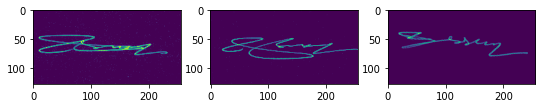

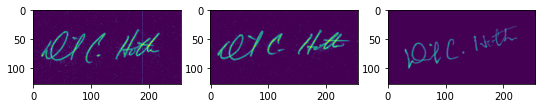

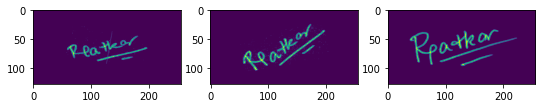

In [37]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize(triplet):
  anchor = Image.open(triplet[0])
  positive = Image.open(triplet[1])
  negative = Image.open(triplet[2])

  fig = plt.figure(figsize=(9, 9))
  axs = fig.subplots(1, 3)

  axs[0].imshow(anchor)
  axs[1].imshow(positive)
  axs[2].imshow(negative)

def rand():
  return int(random.random() * 2038)

for i in range(3):
  visualize(triplets[rand()])

In [38]:
target_shape = (256, 256)

In [39]:
def preprocess(img_path):
  raw = tf.io.read_file(img_path)
  image = tf.image.decode_png(raw, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, target_shape)
  return image

In [40]:
anchor_dataset = []
positive_dataset = []
negative_dataset = []

def load_triplets():
  for triplet in tqdm(triplets):
    anchor_dataset.append( triplet[0].as_posix() )
    positive_dataset.append( triplet[1].as_posix() )
    negative_dataset.append( triplet[2].as_posix() )

load_triplets()

100%|██████████| 4036/4036 [00:00<00:00, 116482.79it/s]


In [41]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_dataset)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_dataset)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_dataset)

In [42]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)

In [43]:
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess(anchor),
        preprocess(positive),
        preprocess(negative),
    )

In [44]:
dataset = dataset.map(preprocess_triplets)

In [45]:
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [46]:
target_shape = (256,256)

base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94781440/94765736 [==============================] - 1s 0us/step


In [47]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [48]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [49]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=1, validation_data=val_dataset)

 13/101 [==>...........................] - ETA: 10:07 - loss: 0.2051

KeyboardInterrupt: ignored

In [ ]:
sample = next(iter(valid))

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

# Simple siamese networks - writed independent approach


# TODO: Importare le triplette del vecchio test set

In [50]:
import itertools as it
import random

triplets_train = []
triplets_test = []

path = dataset_dir / "Train"
content = os.listdir(path)

n = len(content) // 2
n_train = int(n * 0.8)

for i in range(1, n_train):
  folder_g = path / (str(i) + "_genuine")
  folder_f = path / (str(i) + "_forged")
  folder_g_content = os.listdir(path / folder_g)
  folder_f_content = os.listdir(path / folder_f)
  anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
  random.shuffle(anchor_positive)
  for j in range(len(folder_f_content)):
    new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
    triplets_train.append(new_triplet)

for i in range(n_train, n + 1):
  folder_g = path / (str(i) + "_genuine")
  folder_f = path / (str(i) + "_forged")
  folder_g_content = os.listdir(path / folder_g)
  folder_f_content = os.listdir(path / folder_f)
  anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
  random.shuffle(anchor_positive)
  for j in range(len(folder_f_content)):
    new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
    triplets_test.append(new_triplet)

In [51]:
print("Triplette nel train", len(triplets_train))
print("Triplette nel test", len(triplets_test))

Triplette nel train 3725
Triplette nel test 311


In [52]:
image_count = len(triplets_train)

         ANCHOR              POSITIVE            NEGATIVE


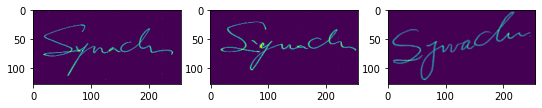

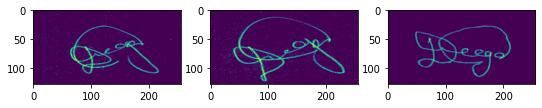

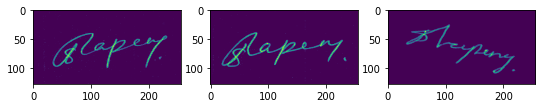

In [53]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize(triplet):
  anchor = Image.open(triplet[0])
  positive = Image.open(triplet[1])
  negative = Image.open(triplet[2])

  fig = plt.figure(figsize=(9, 9))
  axs = fig.subplots(1, 3)

  axs[0].imshow(anchor)
  axs[1].imshow(positive)
  axs[2].imshow(negative)

def rand():
  return int(random.random() * len(triplets_train))

print("         ANCHOR              POSITIVE            NEGATIVE")
for i in range(3):
  visualize(triplets_train[rand()])

In [54]:
target_shape = (128, 256)

In [55]:
def preprocess(img_path):
  raw = tf.io.read_file(img_path)
  image = tf.image.decode_png(raw, channels=1)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, target_shape)
  return image

In [56]:
anchor_dataset = []
positive_dataset = []
negative_dataset = []

def load_triplets():
  for triplet in tqdm(triplets_train):
    anchor_dataset.append( triplet[0].as_posix() )
    positive_dataset.append( triplet[1].as_posix() )
    negative_dataset.append( triplet[2].as_posix() )

load_triplets()

100%|██████████| 3725/3725 [00:00<00:00, 136433.18it/s]


In [57]:
# Da elim
anchor_dataset_test = []
positive_dataset_test = []
negative_dataset_test = []

def load_triplets():
  for triplet in tqdm(triplets_test):
    anchor_dataset_test.append( triplet[0].as_posix() )
    positive_dataset_test.append( triplet[1].as_posix() )
    negative_dataset_test.append( triplet[2].as_posix() )

load_triplets()

100%|██████████| 311/311 [00:00<00:00, 76803.38it/s]


In [58]:
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess(anchor),
        preprocess(positive),
        preprocess(negative),
    )

In [59]:
#da elim
anchor_dataset_test = tf.data.Dataset.from_tensor_slices(anchor_dataset_test)
positive_dataset_test = tf.data.Dataset.from_tensor_slices(positive_dataset_test)
negative_dataset_test = tf.data.Dataset.from_tensor_slices(negative_dataset_test)

In [60]:
#Da elim
dataset_test = tf.data.Dataset.zip((anchor_dataset_test, positive_dataset_test, negative_dataset_test))
dataset_test = dataset_test.shuffle(buffer_size=1024)

In [61]:
#Da elim
dataset_test = dataset_test.map(preprocess_triplets)

In [62]:
#Da elim
dataset_test = dataset_test.batch(1, drop_remainder=False)
dataset_test = dataset_test.prefetch(1)

In [63]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_dataset)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_dataset)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_dataset)

In [64]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)

In [65]:
dataset = dataset.map(preprocess_triplets)

In [66]:
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)


In [67]:
target_shape = (128, 256)

base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(1024, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(512, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(512)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [68]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [69]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [70]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam())
siamese_model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5


ValueError: ignored

In [ ]:
pos_list = []
neg_list = []

for sample in val_dataset:
  anchor, positive, negative = sample
  anchor_embedding, positive_embedding, negative_embedding = (
      embedding(resnet.preprocess_input(anchor)),
      embedding(resnet.preprocess_input(positive)),
      embedding(resnet.preprocess_input(negative)),
  )


  cosine_similarity = metrics.CosineSimilarity()

  positive_similarity = cosine_similarity(anchor_embedding, positive_embedding).numpy()
  pos_list.append(positive_similarity)

  negative_similarity = cosine_similarity(anchor_embedding, negative_embedding).numpy()
  neg_list.append(negative_similarity)

In [ ]:
print("Min delle positive", min(pos_list))
print("Max delle negative", max(neg_list))
if min(pos_list) > max(neg_list):
  print("Esiste una threshold che separa linearmente le due classi")
threshold_val = (min(pos_list) + max(neg_list)) / 2
print("Una threshold possibile è ", threshold_val)

In [ ]:
print("Questa threshold viene applicata al test set per verificare le performance")
tp = 0
tn = 0
for sample in dataset_test:
  anchor, positive, negative = sample
  
  anchor_embedding, positive_embedding, negative_embedding = (
      embedding(resnet.preprocess_input(anchor)),
      embedding(resnet.preprocess_input(positive)),
      embedding(resnet.preprocess_input(negative)),
  )
  cosine_similarity = metrics.CosineSimilarity()

  positive_similarity = cosine_similarity(anchor_embedding, positive_embedding).numpy()
  if positive_similarity > threshold_val: 
    tp += 1

  negative_similarity = cosine_similarity(anchor_embedding, negative_embedding).numpy()
  if negative_similarity < threshold_val:
    tn += 1
  


In [ ]:
print("Accuracy on test set", (tp + tn)/(len(dataset_test)*2))

# Rete siamese - Partendo da CNN senza trasfer learning

In [71]:
import itertools as it
import random

triplets_train = []
triplets_test = []

path = dataset_dir / "Dataset_Siamese"
content = os.listdir(path)

n = len(content) // 2
n_train = int(n * 0.8)

for i in range(1, n_train):
  folder_g = path / (str(i) + "_genuine")
  folder_f = path / (str(i) + "_forged")
  folder_g_content = os.listdir(path / folder_g)
  folder_f_content = os.listdir(path / folder_f)
  anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
  random.shuffle(anchor_positive)
  for j in range(len(folder_f_content)):
    new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
    triplets_train.append(new_triplet)

for i in range(n_train, n + 1):
  folder_g = path / (str(i) + "_genuine")
  folder_f = path / (str(i) + "_forged")
  folder_g_content = os.listdir(path / folder_g)
  folder_f_content = os.listdir(path / folder_f)
  anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
  random.shuffle(anchor_positive)
  for j in range(len(folder_f_content)):
    new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
    triplets_test.append(new_triplet)

In [72]:
print("Triplette nel train", len(triplets_train))
print("Triplette nel test", len(triplets_test))

Triplette nel train 4034
Triplette nel test 376


In [73]:
image_count = len(triplets_train)

In [74]:
target_shape = (128, 256)

In [75]:
def preprocess(img_path):
  raw = tf.io.read_file(img_path)
  image = tf.image.decode_png(raw, channels=1)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, target_shape)
  return image

In [76]:
anchor_dataset = []
positive_dataset = []
negative_dataset = []

def load_triplets():
  for triplet in tqdm(triplets_train):
    anchor_dataset.append( triplet[0].as_posix() )
    positive_dataset.append( triplet[1].as_posix() )
    negative_dataset.append( triplet[2].as_posix() )

load_triplets()

100%|██████████| 4034/4034 [00:00<00:00, 116636.95it/s]


In [77]:
# Da elim
anchor_dataset_test = []
positive_dataset_test = []
negative_dataset_test = []

def load_triplets():
  for triplet in tqdm(triplets_test):
    anchor_dataset_test.append( triplet[0].as_posix() )
    positive_dataset_test.append( triplet[1].as_posix() )
    negative_dataset_test.append( triplet[2].as_posix() )

load_triplets()

100%|██████████| 376/376 [00:00<00:00, 61380.85it/s]


In [78]:
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess(anchor),
        preprocess(positive),
        preprocess(negative),
    )

In [79]:
#da elim
anchor_dataset_test = tf.data.Dataset.from_tensor_slices(anchor_dataset_test)
positive_dataset_test = tf.data.Dataset.from_tensor_slices(positive_dataset_test)
negative_dataset_test = tf.data.Dataset.from_tensor_slices(negative_dataset_test)

In [80]:
#Da elim
dataset_test = tf.data.Dataset.zip((anchor_dataset_test, positive_dataset_test, negative_dataset_test))
dataset_test = dataset_test.shuffle(buffer_size=1024)

In [81]:
#Da elim
dataset_test = dataset_test.map(preprocess_triplets)

In [82]:
#Da elim
dataset_test = dataset_test.batch(1, drop_remainder=False)
dataset_test = dataset_test.prefetch(1)

In [83]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_dataset)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_dataset)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_dataset)

In [84]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

In [85]:
dataset = dataset.map(preprocess_triplets)

In [86]:
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.shuffle(buffer_size=1024)
val_dataset = val_dataset.shuffle(buffer_size=1024)

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)


In [87]:
target_shape = (128, 256, 1)

initializer = tf.keras.initializers.HeNormal(seed=42) 

model = keras.Sequential([
  keras.Input(shape=target_shape),
  layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer=initializer, activation="relu"),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer=initializer, activation="relu"),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer=initializer, activation="relu"),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(256, kernel_size=(3, 3), kernel_initializer=initializer, activation="relu"),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(1024, activation='relu', kernel_initializer=initializer),
  layers.Dropout(0.4),
  layers.Dense(512)
])


In [88]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [89]:
anchor_input = layers.Input(name="anchor", shape=target_shape)
positive_input = layers.Input(name="positive", shape=target_shape)
negative_input = layers.Input(name="negative", shape=target_shape)

distances = DistanceLayer()(
    model(anchor_input),
    model(positive_input),
    model(negative_input),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [90]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [91]:
from keras.callbacks import ModelCheckpoint
fBestModel = dataset_dir.as_posix() + '/bestModel_S.h5'
bm_callback = ModelCheckpoint(fBestModel, monitor='val_loss', verbose=0, saveBestOnly=True)

In [93]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.000025))
siamese_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
 66/101 [==================>...........] - ETA: 2:31 - loss: 0.8230

KeyboardInterrupt: ignored

In [ ]:
pos_list = []
neg_list = []

for sample in val_dataset:
  anchor, positive, negative = sample
  anchor_embedding, positive_embedding, negative_embedding = (
      model(anchor),
      model(positive),
      model(negative),
  )


  cosine_similarity = metrics.CosineSimilarity()

  positive_similarity = cosine_similarity(anchor_embedding, positive_embedding).numpy()
  pos_list.append(positive_similarity)

  negative_similarity = cosine_similarity(anchor_embedding, negative_embedding).numpy()
  neg_list.append(negative_similarity)

In [ ]:
def mean(x):
  return sum(x)/len(x)

In [ ]:
print(mean(pos_list))
print(mean(neg_list))

In [ ]:
print("Min delle positive", min(pos_list))
print("Max delle negative", max(neg_list))
if min(pos_list) > max(neg_list):
  print("Esiste una threshold che separa linearmente le due classi")
threshold_val = (mean(pos_list) + mean(neg_list)) / 2
print("Una threshold possibile è ", threshold_val)

In [ ]:
print("Questa threshold viene applicata al test set per verificare le performance")
tp = 0
tn = 0
for sample in dataset_test:
  anchor, positive, negative = sample
  
  anchor_embedding, positive_embedding, negative_embedding = (
      model(anchor),
      model(positive),
      model(negative),
  )
  cosine_similarity = metrics.CosineSimilarity()

  positive_similarity = cosine_similarity(anchor_embedding, positive_embedding).numpy()
  if positive_similarity >= threshold_val: 
    tp += 1

  negative_similarity = cosine_similarity(anchor_embedding, negative_embedding).numpy()
  if negative_similarity < threshold_val:
    tn += 1
  


In [ ]:
print("Accuracy on test set", (tp + tn)/(len(dataset_test)*2))

## SVM 

# Rete siamese - Transfer Learning from CNN reduced

##Training

In [4]:
import itertools as it
import random

triplets_train = []
triplets_test = []

path = dataset_dir / "Dataset_Siamese"
content = os.listdir(path)

n = len(content) // 2
n_train = int(n * 0.8)

for i in range(1, n_train):
  folder_g = path / (str(i) + "_genuine")
  folder_f = path / (str(i) + "_forged")
  folder_g_content = os.listdir(path / folder_g)
  folder_f_content = os.listdir(path / folder_f)
  anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
  random.shuffle(anchor_positive)
  for j in range(len(folder_f_content)):
    new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
    triplets_train.append(new_triplet)

for i in range(n_train, n + 1):
  folder_g = path / (str(i) + "_genuine")
  folder_f = path / (str(i) + "_forged")
  folder_g_content = os.listdir(path / folder_g)
  folder_f_content = os.listdir(path / folder_f)
  anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
  random.shuffle(anchor_positive)
  for j in range(len(folder_f_content)):
    new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
    triplets_test.append(new_triplet)

In [5]:
print("Triplette nel train", len(triplets_train))
print("Triplette nel test", len(triplets_test))

Triplette nel train 4034
Triplette nel test 376


In [6]:
image_count = len(triplets_train)

In [7]:
target_shape = (128, 256)

In [8]:
def preprocess(img_path):
  raw = tf.io.read_file(img_path)
  image = tf.image.decode_png(raw, channels=1)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, target_shape)
  return image

In [9]:
anchor_dataset = []
positive_dataset = []
negative_dataset = []

def load_triplets():
  for triplet in tqdm(triplets_train):
    anchor_dataset.append( triplet[0].as_posix() )
    positive_dataset.append( triplet[1].as_posix() )
    negative_dataset.append( triplet[2].as_posix() )

load_triplets()

100%|██████████| 4034/4034 [00:00<00:00, 31681.09it/s]


In [10]:
# Da elim
anchor_dataset_test = []
positive_dataset_test = []
negative_dataset_test = []

def load_triplets():
  for triplet in tqdm(triplets_test):
    anchor_dataset_test.append( triplet[0].as_posix() )
    positive_dataset_test.append( triplet[1].as_posix() )
    negative_dataset_test.append( triplet[2].as_posix() )

load_triplets()

100%|██████████| 376/376 [00:00<00:00, 23259.07it/s]


In [11]:
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess(anchor),
        preprocess(positive),
        preprocess(negative),
    )

In [12]:
#da elim
anchor_dataset_test = tf.data.Dataset.from_tensor_slices(anchor_dataset_test)
positive_dataset_test = tf.data.Dataset.from_tensor_slices(positive_dataset_test)
negative_dataset_test = tf.data.Dataset.from_tensor_slices(negative_dataset_test)

In [13]:
#Da elim
dataset_test = tf.data.Dataset.zip((anchor_dataset_test, positive_dataset_test, negative_dataset_test))
dataset_test = dataset_test.shuffle(buffer_size=1024)

In [14]:
#Da elim
dataset_test = dataset_test.map(preprocess_triplets)

In [15]:
#Da elim
dataset_test = dataset_test.batch(1, drop_remainder=False)
dataset_test = dataset_test.prefetch(1)

In [16]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_dataset)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_dataset)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_dataset)

In [17]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

In [18]:
dataset = dataset.map(preprocess_triplets)

In [19]:
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.shuffle(buffer_size=1024)
val_dataset = val_dataset.shuffle(buffer_size=1024)

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)


In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
fBestModel_reduced = dataset_dir.as_posix() + '/bestModel_reduced.h5'
dependencies = {
    'f1_m': f1_m
}
base_model = keras.models.load_model(fBestModel_reduced, custom_objects=dependencies)

In [22]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 30, 128)      0

In [23]:
target_shape = (128, 256, 1)

initializer = tf.keras.initializers.HeNormal(seed=42) 

base_cnn = Model(inputs=base_model.input, outputs=base_model.get_layer('conv2d_3').output)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(1024, activation="relu", kernel_initializer=initializer)(flatten)
dense1 = layers.BatchNormalization()(dense1)
dropout1 = layers.Dropout(0.4)(dense1)
dense2 = layers.Dense(512, activation="relu", kernel_initializer=initializer)(dropout1)
dense2 = layers.BatchNormalization()(dense2)
dropout2 = layers.Dropout(0.4)(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

#trainable = False
#for layer in base_cnn.layers:
#    if layer.name == "conv2d_3":
#        trainable = True
#    layer.trainable = trainable

In [24]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape)
positive_input = layers.Input(name="positive", shape=target_shape)
negative_input = layers.Input(name="negative", shape=target_shape)

distances = DistanceLayer()(
    embedding((anchor_input)),
    embedding((positive_input)),
    embedding((negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [25]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [26]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.000003))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
101/101 [==============================] - 79s 566ms/step - loss: 0.0669 - val_loss: 0.0858
Epoch 2/10
101/101 [==============================] - 62s 560ms/step - loss: 0.0087 - val_loss: 0.0800
Epoch 3/10
101/101 [==============================] - 61s 548ms/step - loss: 0.0016 - val_loss: 0.0786
Epoch 4/10
101/101 [==============================] - 61s 548ms/step - loss: 3.0386e-04 - val_loss: 0.0784
Epoch 5/10
101/101 [==============================] - 60s 542ms/step - loss: 1.1435e-04 - val_loss: 0.0784
Epoch 6/10
101/101 [==============================] - 61s 543ms/step - loss: 4.6461e-05 - val_loss: 0.0783
Epoch 7/10
101/101 [==============================] - 60s 542ms/step - loss: 1.8466e-05 - val_loss: 0.0783
Epoch 8/10
101/101 [==============================] - 62s 550ms/step - loss: 0.0000e+00 - val_loss: 0.0783
Epoch 9/10
101/101 [==============================] - 61s 544ms/step - loss: 0.0000e+00 - val_loss: 0.0783
Epoch 10/10
101/101 [============================

##Testing

In [27]:
model = embedding

In [28]:
pos_list = []
neg_list = []

for sample in val_dataset:
  anchor, positive, negative = sample
  anchor_embedding, positive_embedding, negative_embedding = (
      model(anchor),
      model(positive),
      model(negative),
  )


  cosine_similarity = metrics.CosineSimilarity()

  positive_similarity = cosine_similarity(anchor_embedding, positive_embedding).numpy()
  pos_list.append(positive_similarity)

  negative_similarity = cosine_similarity(anchor_embedding, negative_embedding).numpy()
  neg_list.append(negative_similarity)

In [29]:
def mean(x):
  return sum(x)/len(x)

In [30]:
print(mean(pos_list))
print(mean(neg_list))

0.7735104973499591
0.713603675365448


In [31]:
print("Min delle positive", min(pos_list))
print("Max delle negative", max(neg_list))
if min(pos_list) > max(neg_list):
  print("Esiste una threshold che separa linearmente le due classi")
threshold_val = (mean(pos_list) + mean(neg_list)) / 2
print("Una threshold possibile è ", threshold_val)

Min delle positive 0.7427672
Max delle negative 0.7385299
Esiste una threshold che separa linearmente le due classi
Una threshold possibile è  0.7435570863577036


In [32]:
print("Questa threshold viene applicata al test set per verificare le performance")
tp = 0
tn = 0
for sample in dataset_test:
  anchor, positive, negative = sample
  
  anchor_embedding, positive_embedding, negative_embedding = (
      model(anchor),
      model(positive),
      model(negative),
  )
  cosine_similarity = metrics.CosineSimilarity()

  positive_similarity = cosine_similarity(anchor_embedding, positive_embedding).numpy()
  if positive_similarity >= threshold_val: 
    tp += 1

  negative_similarity = cosine_similarity(anchor_embedding, negative_embedding).numpy()
  if negative_similarity < threshold_val:
    tn += 1
  


Questa threshold viene applicata al test set per verificare le performance


In [33]:
print("Accuracy on test set", (tp + tn)/(len(dataset_test)*2))

Accuracy on test set 0.5718085106382979


## SVM 